### Process_CoreBx_island_refac

Read the interpolated DEMs for the entire island and do volume calcs.
This version was modifed in December 2021

This reads the .nc file created by `CoreBx_island_refac` and is based on earlier `Process_CoreBx_*` files.

TODO:
* Correct aspect ratio on maps?
* Equal axes for all line plots?
* Add colorbars. Add labels to colorbars
* Add a), b), ...
* Remove titles?
* If the x, y labeling changes in CoreBx_multi, then correct here too.

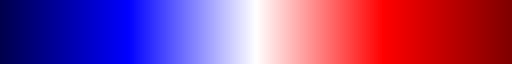

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime
import xarray as xr
import pandas as pd
import pickle
import netCDF4 as netcdf
from scipy import interpolate, signal
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve as astropy_convolve
from scipy.signal import convolve as scipy_convolve
from CoreBx_funcs import *
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# These commands choose fonts that are editable in svg format
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# colors
dblue = '#1f77b4'
red3 = ['#fee0d2','#fc9272','#de2d26']
# oranges from ColorBrewer https://colorbrewer2.org/#type=sequential&scheme=PuBu&n=5
cols=['#feedde','#fdbe85','#fd8d3c','#e6550d','#a63603']
blue5=['#f1eef6','#bdc9e1','#bdc9e1','#2b8cbe','#045a8d']
green5=['#edf8e9','#bae4b3','#74c476','#31a354','#006d2c']
purple5 = ['#f2f0f7','#cbc9e2','#9e9ac8','#756bb1','#54278f']

# This is the colormap made in SurferClr2Cmap.ipynb from NorthCore_ElevationShader_v2.clr
fp = open('cmap_ncb.pkl', 'rb')
cmap_ncb = pickle.load(fp)
fp.close()

# This makes NaN gray
tcmap=cmap_ncb
tcmap.set_bad(color='darkgray')

# This is the difference color map
dcmap = cm.seismic.copy()
dcmap.set_bad(color='darkgray')
dcmap

In [2]:
# Dates for DEMs
dates = ([\
         "2019-08-30",\
         "2019-09-12",\
         "2019-10-11",\
         "2019-11-26",\
         "2020-02-09",\
         "2020-04-09",\
         "2020-08-05",\
         "2020-08-09",\
         "2020-09-28",\
         "2021-05-30"])

dem_path ='C:/crs/proj/2019_DorianOBX/Dorian_paper_analyses/rotated_dems/'

# these offsets are the mean anomaly relative to the 10-map mean per Analyze_rotated_stable_points_refac
offset = np.array([0.00168195,  0.02229009, -0.02397204, -0.01150765, -0.07320715, -0.02726184,
 -0.03547332, -0.02953579, -0.02719979,  0.00756222])

MHHW = 0.4 #elevation of MHHW per VDATUM

# hole-filling options
holes = (["clip","extend"])
ihole = 1 # pick 1 or 2d

# Read in a dict, where analysis region is defined by:
#  name
#  e0 - UTM Easting of origin [m]
#  n0 - UTM Northing of origin [m]
#  xlen - Length of alongshore axis [m]
#  ylen - Length of cross-shore axis [m]
#  dxdy - grid size (must be isotropic right now) [m]
#  theta - rotation CCW from x-axis [deg]
#  xs_end - number of grid cells to approximate limit of overwash terrace
#  d_end - number of grid cells to 
r = yaml2dict('island_box.yml')
print(r)

# initialize maps arrays fo
nmaps = len(dates)
vsum = np.zeros((nmaps))
vsumall = np.zeros((nmaps))
vchange = np.zeros((nmaps-1))
vchangeall = np.zeros((nmaps-1))

statsfn = "island_stats_{}.txt".format(holes[ihole])
sfile = open(statsfn, "w")

print("",file=sfile)
print('Region: ',r['name'],file=sfile)

# read in the multi-map .nc file
fn = r['name']+'.nc'
dsa = xr.open_dataset(dem_path+fn)
dsaa = np.squeeze(dsa.to_array())
nmaps,ncross,nalong=np.shape(dsaa)
print('nmaps, ncross, nalong: ',nmaps,ncross,nalong)

# Correct for uniform offsets
for i in range(0,nmaps):
    dsaa[i,:,:] = dsaa[i,:,:] - offset[i] 

# NaNs below -1m
dsaa = dsaa.where(dsaa>=-0.1)
map_stats(dsaa,sfile)

# read in the multi-map std err .nc file
fn = r['name']+'_stderr.nc'
dse = xr.open_dataset(dem_path+fn)
dser = np.squeeze(dse.to_array())
nmapse,ncrosse,nalonge=np.shape(dser)
print('nmapse, ncrosse, nalonge: ',nmapse,ncrosse,nalonge)

print('Max. std. err: ',np.nanmax(np.ravel(dser)))
print('Min. elev: ',np.nanmin(np.ravel(dsaa)))
print('Max. elev: ',np.nanmax(np.ravel(dsaa)))

{'name': 'ncorebx_refac', 'e0': 378490.0, 'n0': 3855740.0, 'xlen': 36500.0, 'ylen': 1500.0, 'dxdy': 1.0, 'theta': 42.0}
nmaps, ncross, nalong:  10 1500 36500
nmapse, ncrosse, nalonge:  10 1500 36500
Max. std. err:  22.500845
Min. elev:  -0.1
Max. elev:  52.265087


#### `xdist` and `ydist` are numpy arrays with alongshore and cross-shore coordinates for maps
TODO: Someday, try to work with xarray object throughout

In [3]:
xdist = dse['Alongshore'].to_numpy()
ydist = dse['Cross-shore'].to_numpy()

#### Read in the fill map

In [4]:
fnf = r['name']+'_Sep_fill.nc'                
dsf = xr.open_dataset(dem_path+fnf)
dsfa = np.squeeze(dsf.to_array())
ncrossf,nalongf=np.shape(dsfa)
print('ncrossf, nalongf: ',ncrossf,nalongf)

# correct for September offset
dsfa = dsfa+offset[1]

# NaNs below -1 m
dsfa = dsfa.where(dsfa>=-998.) 
stat_summary(np.ravel(dsfa),iprint=True)

ncrossf, nalongf:  1500 36500
  n, nnan, nvalid:  54750000 32755925 21994075
  mean, std, min, max   : 1.190 0.979 -6.618 8.536
  d5, d25, d50, d75, d95: -0.225 0.541 1.076 1.781 2.862


{'n': 54750000,
 'nnan': 32755925,
 'nvalid': 21994075,
 'mean': 1.1903874,
 'std': 0.9786859,
 'min': -6.6182184,
 'max': 8.535785,
 'd5': -0.22517854869365697,
 'd25': 0.541459858417511,
 'd50': 1.0757869482040405,
 'd75': 1.7810751795768738,
 'd95': 2.861711025238037}

#### Read in the digitized profile of dune crest profile; covert to island coords

In [20]:
df=pd.read_csv("C:\\crs\\proj\\2019_DorianOBX\\WayneWright_flights\\CoreBx\\dune_line_2.csv",header = None)


xUTM=df.loc[:,0].values
yUTM=df.loc[:,1].values

xdune,ydune=UTM2Island(xUTM,yUTM)
# y = np.arange(0,nalong+1.)
f = interpolate.interp1d(xdune,ydune,bounds_error=False,fill_value=np.nan)
ydunei = f(xdist)

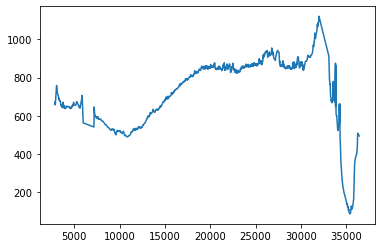

In [6]:
plt.plot(ydunei)

#### Read in the digitized profile for the back side at the ~1.25-m contour interval

Stat summary of island width (iswide)
  n, nnan, nvalid:  36500 3025 33475
  mean, std, min, max   : 245.371 108.560 0.000 584.463
  d5, d25, d50, d75, d95: 60.048 184.311 251.273 310.524 421.068


Text(0, 0.5, 'Cross-shore distance (m)')

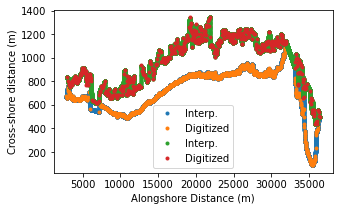

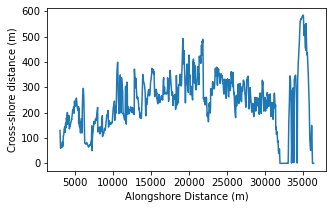

In [7]:
dfb=pd.read_csv("C:\\crs\\proj\\2019_DorianOBX\\WayneWright_flights\\CoreBx\\back_125_2.csv",header = None)
xUTMb=dfb.loc[:,0].values
yUTMb=dfb.loc[:,1].values

# rotate to alongshore/cross-shore coordinates
xback,yback=UTM2Island(xUTMb,yUTMb)

# interpolate
fb = interpolate.interp1d(xback,yback,bounds_error=False,fill_value=np.nan)
ybacki = fb(xdist)

# ensure back >= dune
ybacki[ybacki<ydunei]=ydunei[ybacki<ydunei]
iswide = ybacki-ydunei

print("Stat summary of island width (iswide)")
stat_summary(iswide,iprint=True)

fig = plt.figure(figsize=(5,3))
plt.plot(xdist,ydunei,'.',label="Interp.")
plt.plot(xdune,ydune,'.',label='Digitized')
plt.plot(xdist,ybacki,'.',label="Interp.")
plt.plot(xback,yback,'.',label='Digitized')
plt.legend()
plt.xlabel('Alongshore Distance (m)')
plt.ylabel('Cross-shore distance (m)')

fig = plt.figure(figsize=(5,3))
plt.plot(xdist,iswide,'-')
plt.xlabel('Alongshore Distance (m)')
plt.ylabel('Cross-shore distance (m)')

#### Make a metric that gets big when std. err is big and z is small

In [8]:
erat = dser/dsaa**2
print(np.shape(erat))
print(np.nanmax(np.ravel(erat)))

(10, 1500, 36500)
26863112000000.0


#### NaN out elevation values where erat > some threshold

In [9]:
ethresh = 0.18
dsaan = np.ravel(dsaa.copy())
dsaan[np.ravel(erat)>ethresh]=np.nan
dsaan = np.reshape(dsaan,(10,1500,36500))

#### Make a copy of the elevation array and smooth / hole fill with astropy; widen NaN holes with scipy

In [10]:
%%time
kernel5 = Gaussian2DKernel(x_stddev=.5)
kernel9 = Gaussian2DKernel(x_stddev=1.)
print('Shape of kernel5: ',np.shape(kernel5))
print('Shape of kernel9: ',np.shape(kernel9))
dsss = np.ones_like(dsaan)
dssn = np.ones_like(dsaan)
for imap in range(nmaps):
    # astropy convolve will fill NaN holes
    dsss[imap,:,:] = astropy_convolve(dsaan[imap,:,:],kernel5)
    # scipy convolve will widen NaN holes
    dssn[imap,:,:] = scipy_convolve(dsaan[imap,:,:], kernel5, mode='same', method='direct')

Shape of kernel5:  (5, 5)
Shape of kernel9:  (9, 9)
CPU times: total: 4min 25s
Wall time: 4min 26s


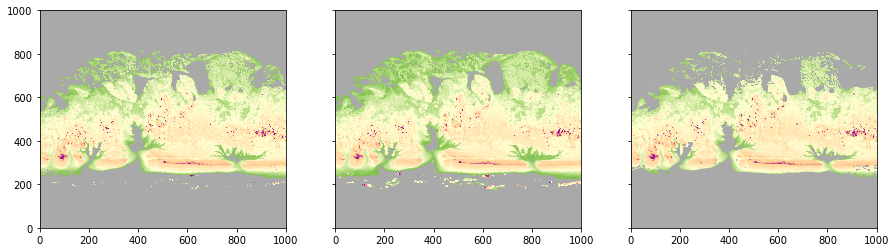

In [11]:
yss = 10000
dxx = 1000
dyy = 1000
imap = 1
xss = 200
xse = xss+dxx
yse = yss + dyy

fix, axes = plt.subplots(1,3,figsize=(15,4),sharey='row')
axes[0].pcolormesh(dsaan[imap,xss:xse,yss:yse],vmin=-1,vmax=6,cmap=cmap_ncb)
axes[1].pcolormesh(dsss[imap,xss:xse,yss:yse],vmin=-1,vmax=6,cmap=cmap_ncb)
axes[2].pcolormesh(dssn[imap,xss:xse,yss:yse],vmin=-1,vmax=6,cmap=cmap_ncb)

### Make 3D difference array

In [12]:
dsdif = np.diff(dsaan,1,0)
print(np.shape(dsdif))

(9, 1500, 36500)


[  0. 400.] [250. 250.]
[  0. 400.] [500. 500.]
[  0. 400.] [750. 750.]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


dist,zc:  296.5 1.7187292575836182
dist,zc:  290.5 1.8033874034881592
dist,zc:  281.5 1.9834800958633423


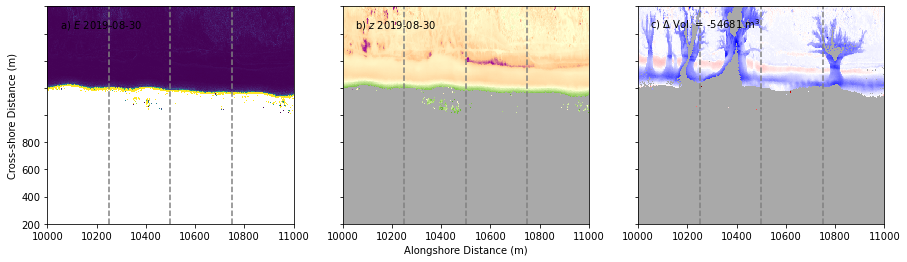

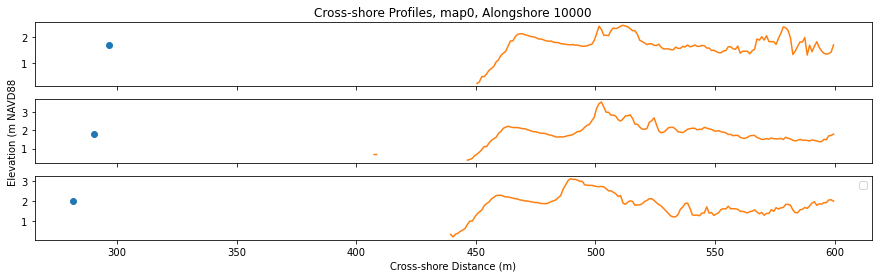

In [13]:
# This is a test map + profile figure that can be relocated

figdir = 'C:/crs/proj/2019_DorianOBX/Dorian_paper_analyses/figs/'

yss = 10000
dxx = 400
dyy = 1000
imap = 0
xss = 200
xse = xss+dxx
yse = yss + dyy

figname = 'prof_map{:d}_{:d}'.format(imap,yss)
dvol = np.nansum(dsdif[imap,xss:xse,yss:yse])
ts = '$\Delta$ Vol. = {:.0f} m$^3$'.format(dvol)
yticks = np.arange(xss,xse+dxx,200)
xticks = np.arange(yss,yse+dyy,200)

fix, axes = plt.subplots(1,3,figsize=(15,4),sharey='row')
axes[0].pcolormesh(erat[imap,xss:xse,yss:yse],vmin=0.0,vmax=.07)
axes[1].pcolormesh(dsaan[imap,xss:xse,yss:yse],vmin=-1,vmax=6,cmap=cmap_ncb)
axes[2].pcolormesh(dsdif[imap,xss:xse,yss:yse],vmin=-5,vmax=5,cmap=dcmap)
for i in range(0,3):
    yvals = np.ones(2)*(i+1)*int(dyy/4)
    xvals = np.array((0.,dxx))
    print(xvals, yvals)
    axes[0].plot(yvals,xvals,'--',c='gray')
    axes[1].plot(yvals,xvals,'--',c='gray')
    axes[2].plot(yvals,xvals,'--',c='gray')
    axes[i].set_xticklabels(xticks)
   
axes[0].text(.05,.9,'a) $E$ '+dates[imap],transform=axes[0].transAxes)
axes[1].text(.05,.9,'b) $z$ '+dates[imap],transform=axes[1].transAxes)
axes[2].text(.05,.9,'c) '+ts,transform=axes[2].transAxes)
axes[0].set_yticklabels(yticks)
axes[0].set_ylabel('Cross-shore Distance (m)')
axes[1].set_xlabel('Alongshore Distance (m)')
plt.savefig(figdir+'map_'+figname+'.jpg',dpi=200)

fig, axes = plt.subplots(3,1,figsize=(15,4),sharex=True)
for i, ax in enumerate(axes):
    izz,izc,izip,zz,zc,zipt = find_toe(ydist[xss:xse],np.squeeze(dsaan[imap,xss:xse,  yss+(i+1)*int(dyy/4)]))
    ax.plot(ydist[izc],zc,'o')
    print('dist,zc: ',ydist[izc],zc)
    ax.plot(ydist[xss:xse],np.squeeze(dsaan[imap,xss:xse,  yss+(i+1)*int(dyy/4)]))
#     ax.plot(np.squeeze(dsaan[imap,xss:xse,  yss+(i+1)*int(dyy/4)]),c=blue5[2],label='$z$ '+dates[imap])
#     ax.plot(np.squeeze(dsaan[imap+1,xss:xse,yss+(i+1)*int(dyy/4)]),c=purple5[2],label='$z$ '+dates[imap+1])
#     ax.plot(np.squeeze(dssn[imap,xss:xse,  yss+(i+1)*int(dyy/4)]),c=blue5[4],label='$zs$ '+dates[imap])
#     ax.plot(np.squeeze(dssn[imap+1,xss:xse,yss+(i+1)*int(dyy/4)]),c=purple5[4],label='$zs$ '+dates[imap+1])
#     ax.plot(np.squeeze(erat[imap,xss:xse,   yss+(i+1)*int(dyy/4)]),c=red3[2],alpha=0.4,label='$E$ '+dates[imap])
#     ax.plot(np.squeeze(erat[imap+1,xss:xse, yss+(i+1)*int(dyy/4)]),c=red3[1],alpha=0.4,label='$E$ '+dates[imap+1])
#     ax.set_ylim((-1.,5.))

axes[2].legend(loc='upper right')
ttext = 'Cross-shore Profiles, map{}, Alongshore {:0d}'.format(imap,yss)
axes[0].set_title(ttext)
axes[-1].set_xlabel('Cross-shore Distance (m)')
axes[1].set_ylabel('Elevation (m NAVD88')
plt.savefig(figdir+'prof_'+figname+'.svg',dpi=200)


#### Single profile for tests

0 0.0 671.6321014567685
nan_frac:  0.815
offshore
izmax= 352 dist= 552.5 elev= 1.9298332
izc= 329 dist= 529.5 elev= 0.3516374315534319
izip= 336 dist= 536.5 elev= 0.8292646
izz= 0 dist= nan elev= nan
0 329 336


<Figure size 432x288 with 0 Axes>

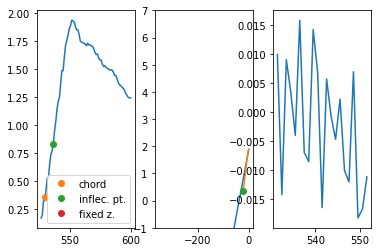

In [14]:
%run -i CoreBx_funcs # used to update when debugging the funcs

#iprof = 17550
#iprof = 35999
iprof = 7000
title_str = 'test pvol'
pnames=['28-Aug','13-Sep','11-Oct','26-Nov']
datum = 0.4 

nprofs = 1

# allocate arrays for profile info
y = np.zeros(nprofs)
v = np.zeros((nmaps,nprofs))
vp = np.zeros((nmaps,nprofs))
vb = np.zeros((nmaps,nprofs))
cxcy = np.zeros((nmaps,nprofs,2))
zmax = v.copy()
dmax = v.copy()
zmax = v.copy()
dmax = v.copy()
zcrest = v.copy()
dcrest = v.copy()
zcrest0 = v.copy()
dtoe_zc = v.copy()
ztoe_zc = v.copy()
width_island = v.copy()
width_platform = v.copy()
width_beach = v.copy()

maxdist = 100.
proff = np.squeeze(np.array((dsaan[:,:,iprof])))
pfill = np.squeeze(np.array((dsfa[:,iprof])))
psmooth = np.squeeze(np.array((dssn[:,:,iprof])))

title_str = '%s_Profile_%s' % (r['name'].capitalize(),iprof)
#title_str = '{0}_Profile_{1}'.format(r['name'].capitalize(),iprof)
i=0
print(i,y[i],ydune[i])

imap = 0
y = ydist[xss:xse]
p = proff[0,xss:xse]

izz,izc,izip,zz,zc,zipt = find_toe(ydist[xss:xse],np.squeeze(proff[0,xss:xse]),debug=True)
    #ax.plot(ydist[izc],zc,'o')
print(izz,izc,izip)
# print('dist,zc: ',ydist[izc],zc)
# print('dist,zz: ',ydist[izz],zz)
# print('dist,zipt: ',ydist[izipt],zipt)

    #ax.plot(ydist[xss:xse],np.squeeze(dsaan[imap,xss:xse,  yss+(i+1)*int(dyy/4)]))


# v[:,i], vp[:,i], vb[:,i], cxcy[:,i,:], zmax[:,i], dmax[:,i], zcrest[:,i], dcrest[:,i], zcrest0[:,i], dtoe_zc[:,i],\
#     ztoe_zc[:,i],width_island[:,i], width_platform[:,i], width_beach[:,i] = \
#       pvol(ydist,proff,pfill,psmooth,ydunei[iprof],ybacki[iprof],\
#       title_str,pnames,imethod='extend',\
#       datum=datum,\
#       maxdist=maxdist,ztoe=2.4,zowp=1.25,nsmooth=51,\
#       iverbose=True,iplot=True,iprint=True)

### Analyze each map using a profile approach
* Load `CoreBx_funcs.py`
* Loop through the four maps and call `pvol` func

In [28]:
%%time
%run -i CoreBx_funcs # used to update when debugging the funcs

# process all of them
dist = np.arange(0,ncross)
title_str = 'test pvol'
pnames=dates
datum = 0.4 

profile_list = range(0,nalong,1)
nprofs = len(profile_list)
print(nprofs, profile_list)

y = np.arange(0.,nalong)
# allocate arrays for profile info
v = np.zeros((nmaps,nprofs))
vp = np.zeros((nmaps,nprofs))
vb = np.zeros((nmaps,nprofs))
cxcy = np.zeros((nmaps,nprofs,2))
zmax = v.copy()
dmax = v.copy()
zmax = v.copy()
dmax = v.copy()
zcrest = v.copy()
dcrest = v.copy()
zcrest0 = v.copy()
dtoe_zz = v.copy()
ztoe_zz = v.copy()
dtoe_zc = v.copy()
ztoe_zc = v.copy()
dtoe_ip = v.copy()
ztoe_ip = v.copy()
width_island = v.copy()
width_platform = v.copy()
width_beach = v.copy()

maxdist = 100.  #starting distance for profiles
for i, iprof in enumerate(profile_list):
    proff = np.squeeze(np.array((dsaa[:,:,iprof])))
    pfill = np.squeeze(np.array((dsfa[:,iprof])))

    title_str = '{0}_Profile_{1}'.format(r['name'].capitalize(),iprof)

    # dunes are farther back in NE portion
    if y[i] >=25000:
        maxdist = 200.
    v[:,i], vp[:,i], vb[:,i], cxcy[:,i], zmax[:,i], dmax[:,i], zcrest[:,i], dcrest[:,i], zcrest0[:,i],\
    dtoe_zz[:,i], ztoe_zz[:,i], dtoe_zc[:,i], ztoe_zc[:,i], dtoe_ip[:,i], ztoe_ip[:,i],\
    width_island[:,i], width_platform[:,i], width_beach[:,i] = \
          pvol(dist, proff, pfill, ydunei[iprof], ybacki[iprof],\
          title_str, pnames, imethod='extend',\
          datum=datum,\
          maxdist=maxdist,ztoe=2.4,zowp=1.25,nsmooth=51,\
          iverbose=False,iplot=False,iprint=False)


36500 range(0, 36500)
CPU times: total: 3min
Wall time: 3min 42s


<Figure size 432x288 with 0 Axes>

In [ ]:
#TODO - Do all months
# put these results in a .csv file via Pandas
for i, mnth in enumerate(['Aug_','Sep_','Oct_','Nov_']):
    exec( mnth+"pmetrics = pd.DataFrame({'y':y.T,'Vol':v[i,:],'Volp':vp[i,:],'Cx':cxcy[i,:,0],'Cy':cxcy[i,:,1],\
        'zmax':zmax[i,:], 'dmax':dmax[i,:], 'zcrest':zcrest[i,:], 'dcrest':dcrest[i,:], 'zcrest0':zcrest0[i,:],\
        'dtoe':dtoe[i,:],'iwidth':width_island[i,:],'pwidth': width_platform[i,:]})" )
    exec(mnth+"pmetrics.to_csv('"+mnth+"_pmetrics.csv',index=False,na_rep='-999.999',float_format='%.3f')")

### Volume calcs

In [29]:
vp_tot = np.nansum(vp,1)
vb_tot = np.nansum(vb,1)
ap_tot = np.nansum(width_platform,1)
ab_tot = np.nansum(width_beach,1)
print('Date       Plat vol Beach vol  P area   B area     Frac. Elev.')
for i, d in enumerate(dates):
    print('{} {:.0f} {:.0f}   {:.0f}  {:.0f}  {:.3f}  {:.2f}'.format(dates[i],vp_tot[i],vb_tot[i],ap_tot[i],ab_tot[i],vp_tot[i]/vp_tot[0],vp_tot[i]/ap_tot[i]))

Date       Plat vol Beach vol  P area   B area     Frac. Elev.
2019-08-30 14874465 3362880   10721490  2506456  1.000  1.39
2019-09-12 11974804 2089358   11685371  3469933  0.805  1.02
2019-10-11 11951924 2415345   11153056  2938074  0.804  1.07
2019-11-26 11666387 2049727   9551142  1334190  0.784  1.22
2020-02-09 11870030 2276089   10446735  2231371  0.798  1.14
2020-04-09 11920723 2411729   10814059  2599112  0.801  1.10
2020-08-05 12480698 2687536   10370364  2154975  0.839  1.20
2020-08-09 12543692 2545692   10784874  2571192  0.843  1.16
2020-09-28 13622902 3014711   11063695  2849912  0.916  1.23
2021-05-30 13050404 2762787   10483448  2266069  0.877  1.24


### Uncertainty on volume calcs

In [31]:
# for platform volumes
sigma_rs = np.ones_like(vp_tot)*np.nan
sigma_sc = sigma_rs.copy()
# for beach volumes
sigma_rsb = sigma_rs.copy()
sigma_scb = sigma_rs.copy()
sigma_rmsd = np.sqrt(2.*0.2**2)
print('sigma_rmsd:',sigma_rmsd)

L2 = 1. # 1-m grid
for imap in range((nmaps)):

    # Uncorrelated random error
    an = ap_tot[imap] # approximate area
    bn = ab_tot[imap]
    print('areas:', an, bn)
    sigma_rs[imap] = sigma_rmsd/np.sqrt(an)
    sigma_rsb[imap] = sigma_rmsd/np.sqrt(bn)

    # Spatially correlated data (max values)
    sill = np.sqrt(0.03)
    sigma_sill = np.sqrt(sill)
    rng = 360.
    sigma_sc[imap] = (sigma_sill/np.sqrt(an)) * np.sqrt((np.pi*rng**2)/(5.*L2))
    sigma_scb[imap] = (sigma_sill/np.sqrt(bn)) * np.sqrt((np.pi*rng**2)/(5.*L2))

    Asc = np.pi*rng**2/(5.*an*L2)
    Ascb = np.pi*rng**2/(5.*bn*L2)

    print('Asc: ',Asc, Ascb)
    
# Systematic error
sigma_sys = 0.07

# total error
sigma_tot = np.sqrt( sigma_rs**2. + sigma_sc**2. + sigma_sys**2.)
sigma_totb = np.sqrt( sigma_rsb**2. + sigma_scb**2. + sigma_sys**2.)

for i in range(nmaps-1):
    # calculate stats for platform and beach widths
    ss=stat_summary(width_platform[i,:],iprint=False)
    ssb=stat_summary(width_beach[i,:],iprint=False)
    print('Platform and beach median widths: {:.3f}, {:.3f}'.format(ss['d50'],ssb['d50']))
    print('sigma_rs:           {:.6f}, {:.6f}'.format(sigma_rs[i], sigma_rsb[i]))
    print('sigma_sc:           {:.6f}, {:.6f}'.format(sigma_sc[i], sigma_scb[i]))
    print('sigma_tot:          {:.6f}, {:.6f}'.format(sigma_tot[i], sigma_totb[i]))

print('ap_tot: ',ap_tot)
print('vp_tot: ',vp_tot)
print('avg. elevation: ',vp_tot/ap_tot)
vdiff = np.diff(vp_tot,1,0)
print('diff(vp_tot):',vdiff)
print('diff as fraction of initial volume: ',vdiff/vp_tot[0])
print('diff per meter',vdiff/36650.)
err = ap_tot*sigma_tot
errb = ab_tot*sigma_totb

print('err volumes',err,errb)
print('err as frac of volume initial volume: ',err/vp_tot[0])
print('err as frac of volume change:',np.mean(err)/vdiff)
print('avg. elevation change: ',vdiff/np.mean(ap_tot))

sigma_rmsd: 0.28284271247461906
areas: 10721490.411014808 2506456.0
Asc:  0.007595033755511229 0.032488135271892836
areas: 11685371.411014808 3469933.0
Asc:  0.006968548856246897 0.023467335415711898
areas: 11153056.411014808 2938074.0
Asc:  0.007301144957953115 0.027715463116670117
areas: 9551142.411014808 1334190.0
Asc:  0.008525690234409926 0.061033347260170914
areas: 10446735.411014808 2231371.0
Asc:  0.007794787402693223 0.036493295637994506
areas: 10814059.411014808 2599112.0
Asc:  0.007530019809037271 0.031329962533760546
areas: 10370364.411014808 2154975.0
Asc:  0.007852190950450791 0.037787019144559654
areas: 10784874.411014808 2571192.0
Asc:  0.00755039683149961 0.031670167603604645
areas: 11063695.411014808 2849912.0
Asc:  0.00736011599704536 0.028572840698606636
areas: 10483448.411014808 2266069.0
Asc:  0.007767490084225532 0.03593451107669159
Platform and beach median widths: 337.630, 74.000
sigma_rs:           0.000086, 0.000179
sigma_sc:           0.036270, 0.075014
sigm

In [ ]:
print("Summary:")
print('Initial island volume, area, and avg. elevation:')

### Summary in words
* Initial island volume was 17.6 million m3, initial area was about 12.5 m2, so inital avg. elevation was 1.47 m
* Uncertainties around these are about 5%
* Volume changes were -2.9 million, -0.31 m, +0.47 million m3
* These changes represent fractional changes of -0.16 -0.02  0.03 of the initial volume
* Uncertainties around these are 32%, 300%, and 200%.
* Average elevation change was -0.24 -0.03  0.04 m; uncertainty in elevation change is about 0.07 m


### Plot total volumes - `island_volume`

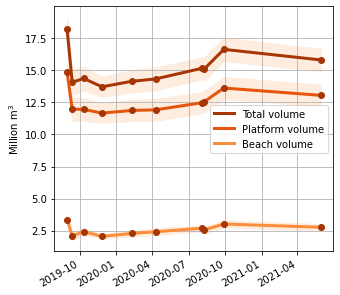

In [41]:
dtl = []
for date in dates:
    dtl.append(datetime.strptime(date, "%Y-%m-%d"))
dt = np.array(dtl)

fig, ax = plt.subplots(1,1,figsize=(5,5))
fig.autofmt_xdate()
#plt.plot(dt,vsumall/1e6,label="Entire island")
errt = np.sqrt(err**2+errb**2)
plt.fill_between(dt, (vp_tot+vb_tot+errt)/1e6, (vp_tot+vb_tot-errt)/1e6,color=cols[0] )
plt.plot(dt,(vp_tot+vb_tot)/1e6,label="Total volume",c=cols[4],linewidth=3)
plt.plot(dt,(vp_tot+vb_tot)/1e6,'o',c=cols[4])


plt.fill_between(dt, (vp_tot+err)/1e6, (vp_tot-err)/1e6,color=cols[0] )
plt.plot(dt,(vp_tot)/1e6,label="Platform volume",c=cols[3],linewidth=3)
plt.plot(dt,(vp_tot)/1e6,'o',c=cols[4])

plt.fill_between(dt, (vb_tot+errb)/1e6, (vb_tot-errb)/1e6,color=cols[0] )
plt.plot(dt,vb_tot/1e6,label="Beach volume",c=cols[2],linewidth=3)
plt.plot(dt,(vb_tot)/1e6,'o',c=cols[4])

plt.ylabel('Million m$^3$')
plt.grid()
plt.legend()
#plt.title('Island Volume')
fig_name = 'island_volume.svg'
plt.savefig(fig_name,bbox_inches='tight', format='svg')
fig_name = 'island_volume.png'
plt.savefig(fig_name,bbox_inches='tight', format='png', dpi = 200)

Text(0, 0.5, 'Area, Volume')

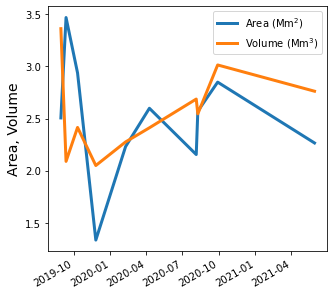

In [56]:
### Plot beach area
fig, ax = plt.subplots(1,1,figsize=(5,5))
fig.autofmt_xdate()
plt.plot(dt,ab_tot/1e6,linewidth=3,label='Area (Mm$^2$)')
plt.plot(dt,vb_tot/1e6,linewidth=3,label='Volume (Mm$^3$)')
plt.legend()
plt.ylabel('Area, Volume',fontsize=14)

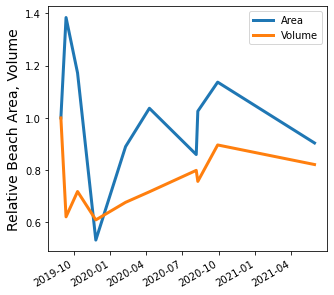

In [58]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
fig.autofmt_xdate()
plt.plot(dt,ab_tot/ab_tot[0],linewidth=3,label='Area')
plt.plot(dt,vb_tot/vb_tot[0],linewidth=3,label='Volume')
plt.ylabel('Relative Beach Area, Volume',fontsize=14)
plt.legend()

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
fig.autofmt_xdate()
plt.plot(dt,vb_tot/vp_tot)

In [ ]:
dtl = []
for date in dates:
    dtl.append(datetime.strptime(date, "%Y-%m-%d"))
dt = np.array(dtl)

fig, ax = plt.subplots(1,1,figsize=(8,4))
fig.autofmt_xdate()
#plt.plot(dt,vsumall/1e6,label="Entire island")
#plt.fill_between(dt, (vp_tot+err)/1e6, (vp_tot-err)/1e6,color=cols[0] )
plt.plot(dt,(vp_tot-vb_tot)/1e6,label="Platform volume",c=cols[3],linewidth=3)
plt.grid()
plt.legend()
#plt.title('Island Volume')
fig_name = 'island_volume.svg'
plt.savefig(fig_name,bbox_inches='tight', format='svg')
fig_name = 'island_volume.png'
plt.savefig(fig_name,bbox_inches='tight', format='png', dpi = 200)

In [ ]:
# average elevation (alongshore)
melev = vp / width_platform
print('Shape of alongshore mean elevation: ',np.shape(melev))
# average elevation difference
melev_diff = np.diff(melev,1,0)
print('Shape of elevation difference: ',np.shape(melev_diff))
for i in range(nmaps-1):
    sstat=stat_summary(melev_diff[i,:],iprint=False)
    print('d50: ',sstat['d50'],'mean',sstat['mean'])

### Island-wide max. elevation, volume, and average elevation

In [ ]:
# mean profile elevations
pelev = vp / width_platform
pelev_diff = np.diff(pelev,1,0)
print("Shape of pelev:",np.shape(pelev))

aug_mean_elev = np.nanmean(pelev[0,:])
aug_std_elev = np.nanstd(pelev[0,:])
aug_err=np.sqrt(aug_std_elev**2+0.08**2)

sep_mean_elev = np.nanmean(pelev[1,:])
sep_std_elev = np.nanstd(pelev[1,:])
sep_err=np.sqrt(sep_std_elev**2+0.08**2)

diff_mean = np.nanmean(pelev_diff[0,:])
diff_std = np.nanmean(pelev_diff[0,:])
diff_err1 = np.sqrt(diff_std**2 + 0.08**2 + 0.08**2)
diff_err2 = np.sqrt(aug_err**2+sep_err**2+ 0.08**2 + 0.08**2)

print('August mean elev: {:.2f} Std: {:.2f} Err: {:.2f}'.format(aug_mean_elev,aug_std_elev,aug_err))
print('Sept mean elev: {:.2f} Std: {:.2f} Err: {:.2f}'.format(sep_mean_elev,sep_std_elev,sep_err))
print('Sept minus Aug elev diff: {:.2f} Std: {:.2f} Err1: {:.2f} Err2: {:.2f}'.format(diff_mean,diff_std,diff_err1,diff_err2))

In [ ]:
# smooth mean profiles
pelev0s = running_mean(pelev[0,:],501)
pelev1s = running_mean(pelev[1,:],501)
pelev1sd = running_stddev(pelev[1,:],501)
pelev_diff1s = running_mean(pelev_diff[0,:],501)

print("Stats for max elevations in August zmax[0,:]:")
s = stat_summary( zmax[0,:], iprint=True)
print("Stats for mean elevations in August pelev[0,:]:")
s = stat_summary( pelev[0,:], iprint=True)
# Elevation difference uncertainty
z_err = np.sqrt( s['std']**2 + .08**2 )
print("Aug mean elevation = {:.2f} +/- {:.2f} (inluding mapping precision error)".format(s['mean'], z_err))
print("Stats for mean elevations in Sep pelev[1,:]:")
s = stat_summary( pelev[1,:], iprint=True)
# Elevation difference uncertainty
z_err = np.sqrt( s['std']**2 + .08**2 )
print("Sep mean elevation = {:.2f} +/- {:.2f} (inluding mapping precision error)".format(s['mean'], z_err))
print("Stats for mean elevation diffs in Sep minus Aug pelev_diff1s:")
s = stat_summary( pelev_diff1s, iprint=True)
# Elevation difference uncertainty
dz_err = np.sqrt( s['std']**2 + .08**2 + .08**2)
print("Mean elevation difference = {:.2f} +/- {:.2f} (inluding mapping precision error)".format(s['mean'], dz_err))

In [ ]:
# island width is wrong in places with no island volume
# TODO: maybe fix this in profile calcs?
width_platform0=width_platform.copy()
width_platform0[vp<=10.]=0.

# average volume
vpmean = np.zeros_like(vp)
vpstd = vpmean.copy()
apmean = vpmean.copy()
apstd = vpmean.copy()

# smooth volumes and widths
for i in range(0,4):
    vpmean[i,:] = running_nanmean(vp[i,:],501)
    vpstd[i,:] = running_stddev(vp[i,:],501)
    apmean[i,:] = running_nanmean(width_platform0[i,:],501)
    apstd[i,:] = running_stddev(width_platform0[i,:],501)

# smooth max elevations in August
x = zmax[0,:]
xs = running_nanmean(x,501)
xstd = running_stddev(x,501)
print(np.shape(x),np.shape(xs))

#vp_err = np.sqrt( vpstd**2 + (width_platform*np.tile(sigma_tot,[nalong,1]).T)**2 ) 

plt.figure(figsize=(12,12))
ax1=plt.subplot(311)
plt.plot(y,np.ones_like(y)*2.5,'--',c='gray')
plt.plot(y,xs,'-',linewidth=3,c=red3[2],label='Aug max')
ax1.fill_between(y,xs-xstd,xs+xstd,color=red3[0])
plt.plot(y,pelev0s,linewidth=3,c=cols[1],label='Aug mean')
plt.plot(y,pelev1s,linewidth=3,c=cols[2],label='Sep mean')
ax1.fill_between(y,pelev1s-pelev1sd,pelev1s+pelev1sd,color=cols[0])
plt.ylim((-2,8))
plt.text(0.02, 0.92,'a',horizontalalignment='left',verticalalignment='center',transform = ax1.transAxes, fontweight='bold')
plt.legend(loc='lower left')
plt.ylabel('Elevation (m NAVD88)')
plt.xlim((0,36500))

ax2=plt.subplot(312)
plt.plot(y,np.ones_like(y)*0.,'--',c='gray')
plt.plot(y,vpmean[0,:],linewidth=3,c=cols[2],label='Aug')
plt.plot(y,vpmean[1,:],linewidth=3,c=cols[3],label='Sep')
ax2.fill_between(y,vpmean[0,:]-vpstd[0,:],vpmean[0,:]+vpstd[0,:],color=cols[0])
ax2.fill_between(y,vpmean[1,:]-vpstd[1,:],vpmean[1,:]+vpstd[1,:],color=cols[0])
plt.text(0.02, 0.92,'b ',horizontalalignment='left',verticalalignment='center',transform = ax2.transAxes, fontweight='bold')
#plt.ylim((-2,8))
plt.ylabel('Volume (m$^3$/m)')
plt.legend(loc='lower left')
plt.xlim((0,36500))
#plt.xlabel('Alongshore distance (m)')

ax3=plt.subplot(313)
plt.plot(y,np.ones_like(y)*0.,'--',c='gray')
plt.plot(y,apmean[0,:],linewidth=3,c=cols[2],label='Aug')
plt.plot(y,apmean[1,:],linewidth=3,c=cols[3],label='Sep')
ax3.fill_between(y,apmean[0,:]-apstd[0,:],apmean[0,:]+apstd[0,:],color=cols[0])
ax3.fill_between(y,apmean[1,:]-apstd[1,:],apmean[1,:]+vpstd[1,:],color=cols[0])
plt.text(0.02, 0.92,'c ',horizontalalignment='left',verticalalignment='center',transform = ax3.transAxes, fontweight='bold')
#plt.ylim((-2,8))
plt.ylabel('Platform width (m)')
plt.legend(loc='lower left')
plt.xlim((0,36500))
plt.xlabel('Alongshore distance (m)')

fig_name = 'island_crest_vol_area.svg'
plt.savefig(fig_name,bbox_inches='tight', format='svg')
fig_name = 'island_crest_vol_area.png'
plt.savefig(fig_name,bbox_inches='tight', format='png', dpi = 200)

### Stats and plots for volume change

In [ ]:
# volume change plots
# average volume
dvmean = np.diff(vp,axis=0)
dvstd = np.nanstd(dvmean,axis=0)
dverr = np.sqrt(dvstd**2+0.08**2+0.08**2)

dvmeans = running_nanmean(dvmean[0,:],501)
dverrs = running_stddev(dverr,501)

print("Stats for volume change:")
s = stat_summary( dvmean[0,:], iprint=True)
print("Stats for volume change uncertainty:")
s = stat_summary( dverr, iprint=True)

plt.plot(dverrs)


### Plot of volume and volume change (two panel) `island_volume_change`

In [ ]:
ax1=plt.subplot(211)
plt.plot(y,np.ones_like(y)*0.,'--',c='gray')
plt.plot(y,vpmean[0,:],linewidth=3,c=cols[2],label='Aug')
plt.plot(y,vpmean[1,:],linewidth=3,c=cols[3],label='Sep')
ax1.fill_between(y,vpmean[0,:]-vpstd[0,:],vpmean[0,:]+vpstd[0,:],color=cols[0])
ax1.fill_between(y,vpmean[1,:]-vpstd[1,:],vpmean[1,:]+vpstd[1,:],color=cols[0])
plt.text(0.02, 0.92,'a ',horizontalalignment='left',verticalalignment='center',transform = ax1.transAxes, fontweight='bold')
#plt.ylim((-2,8))
plt.ylabel('Volume (m$^3$/m)')
plt.legend(loc='center left')
plt.xlim((0,36500))
#plt.xlabel('Alongshore distance (m)')

ax2=plt.subplot(212)
plt.plot(y,np.ones_like(y)*0.,'--',c='gray')
plt.plot(y,dvmeans,linewidth=3,c=cols[2],label='Sep - Aug')
#plt.plot(y,apmean[1,:],linewidth=3,c=cols[3],label='Sep')
ax2.fill_between(y,dvmeans-dverrs,dvmeans+dverrs,color=cols[0])
#ax2.fill_between(y,apmean[1,:]-apstd[1,:],apmean[1,:]+vpstd[1,:],color=cols[0])
plt.text(0.02, 0.92,'b ',horizontalalignment='left',verticalalignment='center',transform = ax2.transAxes, fontweight='bold')
#plt.ylim((-2,8))
plt.ylabel('Volume change (m$^3$/m)')
plt.legend(loc='lower left')
plt.xlim((0,36500))
plt.xlabel('Alongshore distance (m)')

fig_name = 'island_vol_change.svg'
plt.savefig(fig_name,bbox_inches='tight', format='svg')
fig_name = 'island_vol_change.png'
plt.savefig(fig_name,bbox_inches='tight', format='png', dpi = 200)

### Plot of elevation, volume, volume change (3 panel) - `island_crest_vol_dvol`

In [ ]:
plt.figure(figsize=(12,12))
ax1=plt.subplot(311)
plt.plot(y,np.ones_like(y)*2.5,'--',c='gray')
plt.plot(y,xs,'-',linewidth=3,c=red3[2],label='Aug max')
ax1.fill_between(y,xs-xstd,xs+xstd,color=red3[0])
plt.plot(y,pelev0s,linewidth=3,c=cols[2],label='Aug mean')
plt.plot(y,pelev1s,linewidth=3,c=cols[3],label='Sep mean')
ax1.fill_between(y,pelev1s-pelev1sd,pelev1s+pelev1sd,color=cols[0])
plt.ylim((-2,8))
plt.text(0.02, 0.92,'a',horizontalalignment='left',verticalalignment='center',transform = ax1.transAxes, fontweight='bold')
plt.legend(loc='lower left')
plt.ylabel('Elevation (m NAVD88)')
plt.xlim((0,36500))

ax2=plt.subplot(312)
plt.plot(y,np.ones_like(y)*0.,'--',c='gray')
plt.plot(y,vpmean[0,:],linewidth=3,c=cols[2],label='Aug')
plt.plot(y,vpmean[1,:],linewidth=3,c=cols[3],label='Sep')
ax2.fill_between(y,vpmean[0,:]-vpstd[0,:],vpmean[0,:]+vpstd[0,:],color=cols[0])
ax2.fill_between(y,vpmean[1,:]-vpstd[1,:],vpmean[1,:]+vpstd[1,:],color=cols[0])
plt.text(0.02, 0.92,'b ',horizontalalignment='left',verticalalignment='center',transform = ax2.transAxes, fontweight='bold')
#plt.ylim((-2,8))
plt.ylabel('Volume (m$^3$/m)')
plt.legend(loc='lower left')
plt.xlim((0,36500))
#plt.xlabel('Alongshore distance (m)')

ax3=plt.subplot(313)
plt.plot(y,np.ones_like(y)*0.,'--',c='gray')
plt.plot(y,dvmeans,linewidth=3,c=cols[3],label='Sep minus Aug')
ax3.fill_between(y,dvmeans-dverrs,dvmeans+dverrs,color=cols[0])
plt.text(0.02, 0.92,'c ',horizontalalignment='left',verticalalignment='center',transform = ax3.transAxes, fontweight='bold')
plt.ylabel('Volume change (m$^3$/m)')
plt.legend(loc='lower left')
plt.xlim((0,36500))
plt.xlabel('Alongshore distance (m)')

fig_name = 'island_crest_vol_dvol.svg'
plt.savefig(fig_name,bbox_inches='tight', format='svg')
fig_name = 'island_crest_vol_dvol.png'
plt.savefig(fig_name,bbox_inches='tight', format='png', dpi = 200)

   ### Plots of volume change v. island elevation - `volume_change_v_elev`

In [ ]:
# pelev = vp / width_platform
# dvmean
%run -i CoreBx_funcs
bin_edges = [.25, .75, 1.25, 1.75, 2.25, 2.75]
nbins = len(bin_edges)-1
print('nbins=',nbins)
pm = np.ones(nbins)*np.nan
pstd = pm.copy()
dvm = pm.copy()
dvstd = pm.copy()
for i in range(nbins):
    pm[i]=np.nanmean(pelev[0,(pelev[0,:]>=bin_edges[i])&(pelev[0,:]<bin_edges[i+1])])
    pstd[i]=np.nanstd(pelev[0,(pelev[0,:]>=bin_edges[i])&(pelev[0,:]<bin_edges[i+1])])
    dvm[i]=np.nanmean(dvmean[0,(pelev[0,:]>=bin_edges[i])&(pelev[0,:]<bin_edges[i+1])])
    dvstd[i]=np.nanmean(dvmean[0,(pelev[0,:]>=bin_edges[i])&(pelev[0,:]<bin_edges[i+1])])

n, slope, intercept, r2, p, stderr = nanlsfit(pelev[0,:],dvmean[0,:])
    
plt.figure(figsize=(5,5))  
plt.plot(pelev[0,:],dvmean[0,:],'.',color='lightgray',zorder=1)
plt.plot(pm,intercept+pm*slope,'--',color=cols[3],linewidth=2,zorder=2)
plt.errorbar(pm, dvm, xerr=pstd, yerr=dvstd, fmt='ok', ecolor=cols[2], elinewidth=2,zorder=3)
plt.xlabel('Mean August elevation (m NAVD88)',fontsize=14)
plt.ylabel('Volume change Sep minus Aug (m$^3$/m)',fontsize=14)
fig_name = 'volume_change_v_mean_elev.svg'
plt.savefig(fig_name,bbox_inches='tight', format='svg')
fig_name = 'volume_change_v_mean_elev.png'
plt.savefig(fig_name,bbox_inches='tight', format='png', dpi = 200)

### Load and plot wrack statistics - `wrack_elev_island`

In [ ]:
# This is the old plot with stair-step bin averages
# green5=['#edf8e9','#bae4b3','#74c476','#31a354','#006d2c']
# df=pd.read_csv("NCB_Wrack_statistics.csv",header = 0)

# wx = df['X_point_avg'].values
# wy = df['Y_point_avg'].values
# walong, wacross = UTM2Island(wx,wy)

In [ ]:
# read updated wrack statistics from Jin-Si
df=pd.read_csv('C:/crs/proj/2019_DorianOBX/WayneWright_flights/CoreBx/NCB_Wrack_line_ebk.csv',header = 0)

In [ ]:
plt.figure(figsize=(12,8))
ax1=plt.subplot(211)
plt.plot(df['Xisl_500m_avg'],df['Wrack_Elev_500m_avg'].values+df['STD_500m'].values,'--',c='saddlebrown',alpha=.6)
plt.plot(df['Xisl_500m_avg'],df['Wrack_Elev_500m_avg'].values-df['STD_500m'].values,'--',c='saddlebrown',alpha=.6)
plt.plot(df['Xisl_500m_avg'],df['Wrack_Elev_500m_avg'].values,linewidth=3,c='saddlebrown',label="Wrack Elevation")
plt.ylim((0, 3))
#plt.text(0.02, 0.92,'a',horizontalalignment='left',verticalalignment='center',transform = ax1.transAxes, fontweight='bold')
plt.legend(fontsize=14)
plt.ylabel('Elevation (m NAVD88)',fontsize=14)
plt.xlim((0,36500))
plt.xlabel('Alongshore Distance (m)',fontsize=14)
fig_name = 'wrack_elev_island.svg'
plt.savefig(fig_name,bbox_inches='tight', format='svg')
fig_name = 'wrack_elev_island.png'
plt.savefig(fig_name,bbox_inches='tight', format='png', dpi = 200)

### Island-wide dune crest elevations - `dune_crest_diff`

`zcrest0` is the elevation of the dune crest in August, and the elevations of the same location in subsequent years

* Smooth the curves
* plot dune crest elevations for Aug, Sep, and Nov
* plot dune crest changes


In [ ]:
%run -i CoreBx_funcs
x0s = running_mean(zcrest0[0,:],501)
x1s = running_mean(zcrest0[1,:],501)
x2s = running_mean(zcrest0[2,:],501)
x3s = running_mean(zcrest0[3,:],501)
print('Aug zcrest0')
stat_summary(zcrest0[0,:],iprint=True)
print('Sep zcrest0')
stat_summary(zcrest0[1,:],iprint=True)

x0m = running_nanmin(zcrest0[0,:],501)
x1m = running_nanmin(zcrest0[1,:],501)
x2m = running_nanmin(zcrest0[2,:],501)
x3m = running_nanmin(zcrest0[3,:],501)

#stat_summary(x1m,iprint=True)

plt.figure(figsize=(12,8))
ax1=plt.subplot(211)
#plt.plot(y,np.ones_like(y)*2.5,'--',c='gray')
# plt.plot(y,x0s,'-',linewidth=3,c=cols[1],label=pnames[0])
# plt.plot(y,x1s,'-',linewidth=3,c=cols[2],label=pnames[1])
# #plt.plot(y,x2s,'-',linewidth=3,c=cols[3],label=pnames[2])
# plt.plot(y,x3s,'-',linewidth=3,c=cols[4],label=pnames[3])
plt.plot(y,np.ones_like(y)*0.,'--',c='gray')
plt.plot(y,zcrest0[1,:],'-',linewidth=3,c=cols[1],label=pnames[1],alpha=.6)
plt.plot(y,zcrest0[0,:],'-',linewidth=3,c=cols[3],label=pnames[0])

#plt.plot(y,x2s,'-',linewidth=3,c=cols[3],label=pnames[2])
#plt.plot(y,zcrest0[3,:],'-',linewidth=3,c=cols[4],label=pnames[3])

plt.plot(df['Xisl_500m_avg'],df['Wrack_Elev_500m_avg'].values+df['STD_500m'].values,'--',c='saddlebrown',alpha=.6)
plt.plot(df['Xisl_500m_avg'],df['Wrack_Elev_500m_avg'].values-df['STD_500m'].values,'--',c='saddlebrown',alpha=.6)
plt.plot(df['Xisl_500m_avg'],df['Wrack_Elev_500m_avg'].values,linewidth=3,c='saddlebrown',label="Wrack Elevation")

#plt.text(0.02, 0.92,'a',horizontalalignment='left',verticalalignment='center',transform = ax1.transAxes, fontweight='bold')
plt.ylabel('Dune crest (m NAVD88)',fontsize=16)
plt.legend()
plt.ylim((-2.,8.))
plt.xlim((0,36500))

xds0 = running_mean( zcrest0[1,:]-zcrest0[0,:], 501)
xds1 = running_mean( zcrest0[2,:]-zcrest0[0,:], 501)
xds2 = running_mean( zcrest0[3,:]-zcrest0[0,:], 501)

ax2=plt.subplot(212)
plt.plot(y,np.ones_like(y)*0.,'--',c='gray')

plt.plot(y,xds0,'-',linewidth=3,c=blue5[3],label=pnames[1]+' minus '+pnames[0])
#plt.plot(y,xds1,'-',linewidth=3,c=blue5[3],label=pnames[2]+' minus '+pnames[0])
#plt.plot(y,xds2,'-',linewidth=3,c=blue5[4],label=pnames[3]+' minus '+pnames[0])
plt.legend()
#plt.text(0.02, 0.92,'b',horizontalalignment='left',verticalalignment='center',transform = ax2.transAxes, fontweight='bold')
plt.ylabel('Dune crest change (m)',fontsize=16)
plt.xlim((0,36500))
plt.xlabel('Alongshore distance (m)',fontsize=16)

fig_name = 'dune_crest_diff.svg'
plt.savefig(fig_name,bbox_inches='tight', format='svg')
fig_name = 'dune_crest_diff.png'
plt.savefig(fig_name,bbox_inches='tight', format='png', dpi = 200)

In [ ]:
print('wrack elevations')
stat_summary(df['Wrack_Elev_500m_avg'].values,iprint=True)
print('zcrest:')
stat_summary(zcrest[1,:]-zcrest[0,:],iprint=True)
num_bins = 10
bins = np.arange(-2.75,.25,.25)
print(bins)
fig, ax = plt.subplots(figsize=(4,3))

#histogram of the data
n, bins, patches = ax.hist(xds0, bins)

ax.set_xlabel('Sep to Aug Dune Crest Change (m)')
ax.set_ylabel('Number')
#ax.set_title(r'Dune Crest Change')
fig.tight_layout()
plt.show()
plt.savefig('crest_change_histogram.png',bbox_inches='tight', format='png', dpi = 200,c=blue5[2])

### Compare crest heights with volume change - `dune_crest_v_volume_change`

In [ ]:
%run -i CoreBx_funcs
bin_edges = [ .5, 1., 1.5, 2, 2.5, 3., 3.5, 4, 4.5, 5, 5.5, 6, 6.5]
nbins = len(bin_edges)-1
print('nbins=',nbins)
zcm = np.ones(nbins)*np.nan
zcstd = zcm.copy()
dvm = zcm.copy()
dvstd = zcm.copy()
for i in range(nbins):
    zcm[i]=np.nanmean(zcrest0[0,(zcrest[0,:]>=bin_edges[i])&(zcrest[0,:]<bin_edges[i+1])])
    zcstd[i]=np.nanstd(zcrest0[0,(zcrest[0,:]>=bin_edges[i])&(zcrest[0,:]<bin_edges[i+1])])
    dvm[i]=np.nanmean(dvmean[0,(zcrest[0,:]>=bin_edges[i])&(zcrest[0,:]<bin_edges[i+1])])
    dvstd[i]=np.nanmean(dvmean[0,(zcrest[0,:]>=bin_edges[i])&(zcrest[0,:]<bin_edges[i+1])])

n, slope, intercept, r2, p, stderr = nanlsfit(zcrest0[0,:],dvmean[0,:])

plt.figure(figsize=(5,5)) 
plt.plot(zcrest0[0,:],dvmean[0,:],'.',color='lightgray',zorder=1)
plt.errorbar(zcm, dvm, xerr=zcstd, yerr=dvstd, fmt='ok', ecolor=cols[2], elinewidth=2)
plt.plot(zcm,zcm*slope+intercept,'--',c=cols[3])
plt.xlabel('August dune crest elevation (m NAVD88)',fontsize=14)
plt.ylabel('Volume change Sep minus Aug (m$^3$/m)',fontsize=14)
fig_name = 'dune_crest_v_volume_change.svg'
plt.savefig(fig_name,bbox_inches='tight', format='svg')
fig_name = 'dune_crest_v_volume_change.png'
plt.savefig(fig_name,bbox_inches='tight', format='png', dpi = 200)

In [ ]:
# analyze island segments
sl = 3000
segs = np.arange(0,nalong,sl)
sn = 6
ss = segs[sn] 
se = ss+sl
print(len(segs))
print("Segments:",ss)

dtoe_s0 = signal.medfilt(dtoe[0,:], kernel_size=101)
dtoe_s1 = signal.medfilt(dtoe[1,:], kernel_size=101)
plt.figure(figsize=(12,7))
ax1=plt.subplot(211)
plt.plot(y[ss:se],dtoe_s0[ss:se],'.',label='Aug')
plt.plot(y[ss:se],dtoe_s1[ss:se],'.',label='Sep')
plt.plot(y[ss:se],ybacki[ss:se],label='Platform')
plt.legend()

ax2=plt.subplot(212)
dtoe_diff = dtoe_s1[ss:se]-dtoe_s0[ss:se]
plt.plot(y[ss:se],dtoe_diff,'.')
plt.ylabel('Dune toe movement (m)')

# for sn, seg in enumerate(segs):
#     ss = seg
#     se = ss+sl
#     plt.figure(figsize=(12,7))
#     ax1=plt.subplot(211)
#     plt.plot(y[ss:se],dtoe_s0[ss:se],'.')
#     plt.plot(y[ss:se],dtoe_s1[ss:se],'.')
#     plt.plot(y[ss:se],dowp[0,ss:se])

#     ax2=plt.subplot(212)
#     dtoe_diff = dtoe_s0[ss:se]-dtoe_s1[ss:se]
#     plt.plot(y[ss:se],dtoe_diff,'.')


In [ ]:
# experiment with various smoothers
if False:
    # smooth first, then difference w/ median filter
    zmax_s0 = signal.medfilt(zmax[0,:], kernel_size=11)
    zmax_s1 = signal.medfilt(zmap0[1,:], kernel_size=11)
    zdiff = zmax_s1-zmax_s0
    zdiff[zdiff>=-0.5]=0.
    
if False:
    # difference first, then smooth
    zmax_0 = zmax[0,:]
    zmax_1 = zmap0[1,:]
    zdiff = zmax_1-zmax_0
    zdiff[zdiff>=-0.5]=0.
    
if True:
    npts = 5
    chdiff = running_nanmean(zcrest0[1,:]-zcrest0[0,:],npts)

cthresh=2.5
chSep = zcrest0[1,:].copy()
chSep[chSep>=cthresh]=cthresh
chSep = chSep-cthresh
chSep[ ~np.isfinite(chSep)] = 0.
plt.plot(y[ss:se],-chSep[ss:se])
print(np.sum(np.isfinite(chSep)))
#plt.plot(y[ss:se],zmax_s0[ss:se])

In [ ]:
%run -i CoreBx_funcs
vthresh=.5 # threshold for minimum channel depth
nc, channel_ctr, channel_area, channel_width, channel_max_depth, channel_avg_depth = analyze_channels(y,-chSep,vthresh=vthresh)
print('September:')
print('Chanel depths:')
cz0 = stat_summary(channel_avg_depth,iprint=True)
print('Chanel widths:')
cw0 = stat_summary(channel_width,iprint=True)
print('Channel areas:')
ca0 = stat_summary(channel_area,iprint=True)
print('Avg depth: N: {} Mean: {:.2f} Min: {:.2f} Max: {:.2f}'.format(cw0['n'],cz0['mean'],cw0['min'],cw0['max']))
print('Width: N: {} Mean: {:.2f} Min: {:.2f} Max: {:.2f}'.format(cw0['n'],cw0['mean'],cw0['min'],cw0['max']))
print('Area:  N: {} Mean: {:.2f} Min: {:.2f} Max: {:.2f}'.format(cw0['n'],ca0['mean'],ca0['min'],ca0['max']))

In [ ]:
# write to a .csv via Pandas
channel_metrics = pd.DataFrame({'Center':channel_ctr,'Area':channel_area,'Width':channel_width,\
                                'Max depth':channel_max_depth,'Avg_depth':channel_avg_depth})
channel_metrics.to_csv('channel_metrics.csv',index=False,float_format='%.4f')
# stats for those wider than 5 m
pd.set_option("display.precision", 1)
channel_metrics.loc[channel_metrics['Width']>=5.].describe()


In [ ]:
# put these results in a .csv file via Pandas
for i, mnth in enumerate(['Aug_','Sep_','Oct_','Nov_']):
    exec( mnth+"pmetrics = pd.DataFrame({'y':y.T,'Vol':v[i,:],'Volp':vp[i,:],'Cx':cxcy[i,:,0],'Cy':cxcy[i,:,1],\
        'zmax':zmax[i,:], 'dmax':dmax[i,:], 'zcrest':zcrest[i,:], 'dcrest':dcrest[i,:], 'zcrest0':zcrest0[i,:],\
        'dtoe':dtoe[i,:],'iwidth':width_island[i,:],'pwidth': width_platform[i,:]})" )
    exec(mnth+"pmetrics.to_csv('"+mnth+"_pmetrics.csv',index=False,na_rep='-999.999',float_format='%.3f')")

In [ ]:
ia = np.where(channel_area>=5.)
print('Number of channels with area >=5:',np.shape(ia))
s = np.array(channel_area[ia])
col = np.array(channel_avg_depth[ia])

plt.figure(figsize=(8,6))
ax1=plt.subplot(111)
plt.plot(y,np.ones_like(y)*vthresh,'--',c='gray')
plt.scatter(channel_ctr[ia],channel_avg_depth[ia],s,np.log10(s),cmap=plt.cm.winter)
plt.ylim((3.5,0))
plt.ylabel('Channel depth (m)')
plt.xlim((0,36500))
#plt.text(0.02, 0.92,'a',horizontalalignment='left',verticalalignment='center',transform = ax1.transAxes, fontweight='bold')
plt.clim((0,3.5))
cbar=plt.colorbar()
cbar.ax.set_ylabel('log$_{10}$[Channel area (m$^2$)]')
plt.xlim((0,36500))
plt.xlabel('Alongshore distance (m)')
plt.savefig('channel_depth_bubbles.png',bbox_inches='tight', format='png', dpi = 200)

plt.figure(figsize=(8,6))
ax1=plt.subplot(211)
plt.plot(y,np.ones_like(y)*vthresh,'--',c='gray')
plt.plot(channel_ctr[ia],channel_avg_depth[ia],'.',markersize=12,color=blue5[3])
plt.ylim((3.5,0))
plt.ylabel('Channel depth (m)')
plt.xlim((0,36500))
plt.text(0.02, 0.92,'a',horizontalalignment='left',verticalalignment='center',transform = ax1.transAxes, fontweight='bold')

ax2=plt.subplot(212)
plt.plot(channel_ctr[ia],channel_area[ia],'.',markersize=12,color=blue5[3])
plt.ylim((0,3600))
plt.ylabel('Channel area (m$^{-2}$)')
plt.xlim((0,36500))
plt.xlabel('Alongshore distance (m)')
plt.text(0.02, 0.92,'b',horizontalalignment='left',verticalalignment='center',transform = ax2.transAxes, fontweight='bold')


In [ ]:
# remove one weird point - this might be the channel that connects to the back
ibad = np.argwhere(channel_avg_depth>=3)
print('Removing data point at: ',ibad)
print('...where channel_avg_depth = ',channel_avg_depth[ibad])
channel_avg_depth[ibad]=channel_avg_depth[ia].mean()
channel_area[ibad]=channel_area[ia].mean()
channel_width[ibad]=channel_area[ibad]/channel_avg_depth[ibad]

In [ ]:
binw = 1000.
bins = np.arange(0.,36001.,binw)
print('Bin edges: ',bins)

bin_ctr = bins[0:-1]+0.5*binw
ychan = channel_ctr[ia]
data = channel_avg_depth[ia]
digitized = np.digitize(ychan, bins)
bin_mean = [data[digitized == i].mean() for i in range(1, len(bins))]
bin_std = [data[digitized == i].std() for i in range(1, len(bins))]

# hydraulic radius
Rh = channel_area/(2.*channel_avg_depth+channel_width)
stat_summary(Rh[ia],iprint=True)
data= Rh[ia]
Rh_mean = [data[digitized == i].mean() for i in range(1, len(bins))]
Rh_std = [data[digitized == i].std() for i in range(1, len(bins))]

plt.figure(figsize=(12,3))

plt.bar(channel_ctr[ia],channel_avg_depth[ia],width=channel_width[ia],color=blue5[3])
plt.plot(bin_ctr,bin_mean,'-',color=blue5[4],linewidth=2,label='Mean channel depth')
plt.plot(bin_ctr,Rh_mean,'--',color=cols[3],linewidth=2,label='Hydraulic radius')
plt.ylim((3.5,0))
plt.xlabel('Alongshore distance (m)',fontsize=16)
plt.ylabel('Channel depth (m)',fontsize=16)
plt.legend()
plt.xlim((0,36500))
plt.savefig('channel_depth_bars.png',bbox_inches='tight', format='png', dpi = 200)

In [ ]:
print('Channel area (m2):')
stat_summary(channel_area[ia],iprint=True)
num_bins = 15
#bins = np.arange(-2.75,.25,.25)
#print(bins)
fig, ax = plt.subplots()

n, bins, patches = ax.hist(np.log10(channel_area[ia]), num_bins)

ax.set_xlabel('log$_{10}$ [ Channel area (m$^{2}$) ]')
ax.set_ylabel('Number')
#ax.set_title(r'Dune Crest Change')
fig.tight_layout()
plt.show()
plt.savefig('channel_area_histogram.png',bbox_inches='tight', format='png', dpi = 200)

### Estimate flow velocity and total discharge

https://en.wikipedia.org/wiki/Manning_formula

http://www.fsl.orst.edu/geowater/FX3/help/8_Hydraulic_Reference/Mannings_n_Tables.htm

In [ ]:
### Estimate flow velocity using open-channel flow formula
ychan = channel_ctr[ia]
depth=channel_avg_depth[ia]

mann=.025
mann_rough = 0.03
mann_smooth = 0.02
Slope = 1./300.
konv=1.
rhow = 1027.
rhos = 2650.
d50 = 0.43e-3 # Ruggerio, S. Core Banks
d90 = 1.e-3
# print("Base case")

# d50 = 0.25e-3 # Ruggerio, S. Core Banks
# d90 = 0.34e-3
# print("Fine Sediment case")

# Slope = 1./400.
# print("Low slope case")

# Slope = 1./200.
# print("High slope case")

#mann = 0.02
# print("Smooth n case")

# mann = 0.03
# print("Rough n case")

print("Mannings n {:.3f}, slope {:.4f}, d50 (mm) {:.3f}, d90 (mm) {}".\
     format(mann, Slope, d50*1000, d90*1000))
s = rhos/rhow
nu = 1.36e-6
print('s: ',s)
g = 9.81
Dstar = (g*(s-1)/nu**2)**(1./3.)*d50 # Soulsby eqn 99
ws = (nu/d50)*(np.sqrt(10.36**2+1.049*Dstar**3)-10.36) # Soulsby eqn 102
wstar = ws/((g*(s-1)/nu**2)**(1./3.))
print('Dstar:',Dstar,'ws:',ws,'wstar: ',wstar)

theta_cr = (0.3/(1.+1.2*Dstar))+0.055*(1.-np.exp(-0.020*Dstar)) # Soulsby eqn 77
tauc = theta_cr*(g*rhow*(s-1)*d50)
print('Tauc =',tauc)

# fric = 0.04 # Fig. 3.3 in Dyer - not used
# Cdf = fric/8.
Cdn =   g*mann**2/(depth**(1./3.))

print("Cdn")
stat_summary(Cdn,iprint=True)
Vel   = (konv/mann)*Rh[ia]**(2./3.)*np.sqrt(Slope)
Vello = (konv/mann_rough)*Rh[ia]**(2./3.)*np.sqrt(Slope)
Velhi = (konv/mann_smooth)*Rh[ia]**(2./3.)*np.sqrt(Slope)

Froude = Vel/np.sqrt(g*depth)
tau0   = Cdn*rhow*Vel**2.


print("Froude from Manning")
stat_summary(Froude,iprint=True)
print("Velocity from Manning")
stat_summary(Vel,iprint=True)
print("Tau0 from Manning")
stat_summary(tau0,iprint=True)

### Estimate bed stress from bottom stress
# These give similar, but slightly higher numbers
# taub = rhow*g*depth*Slope[1]
# Ubar = np.sqrt(taub/(rhow*Cdn))
# print('Ubar from slope')
# stat_summary(Ubar,iprint=True)
# print('Taub from slope')
# stat_summary(taub,iprint=True)

# Van Rijn (Eqn 133)
Ucr = 0.19*d50**0.1*np.log10(4.*depth/d90)
if d50>0.5e-3:
    Ucr = 8.5*d50**0.6*np.log10(4.*depth/d90)
Ubar = Vel
curly = (Ubar-Ucr)/np.sqrt((s-1)*g*d50)
qbvr = 0.005*Ubar*depth*curly**2.4*(d50/depth)**1.2
qsvr = 0.012*Ubar*depth*curly**2.4*(d50/depth)*Dstar**(-.6)

Ubar = Vello
curly = (Ubar-Ucr)/np.sqrt((s-1)*g*d50)
qbvrlo = 0.005*Ubar*depth*curly**2.4*(d50/depth)**1.2
qsvrlo = 0.012*Ubar*depth*curly**2.4*(d50/depth)*Dstar**(-.6)

Ubar = Velhi
curly = (Ubar-Ucr)/np.sqrt((s-1)*g*d50)
qbvrhi = 0.005*Ubar*depth*curly**2.4*(d50/depth)**1.2
qsvrhi = 0.012*Ubar*depth*curly**2.4*(d50/depth)*Dstar**(-.6)

### Write sed transport calcs to a .csv via Pandas

In [ ]:
flow_calcs = pd.DataFrame({'Center [m]':ychan,'Area [m2]':channel_area[ia],'Width [m]':channel_width[ia],\
                                'Max depth [m]':channel_max_depth[ia],'Avg_depth [m]':channel_avg_depth[ia],\
                          'Velocity [m/s]':Vel,'Bedload [m2/s]':qbvr,'Sus load [m2/s]':qsvr,\
                           'Qwater [m3/s]':Vel*channel_area[ia],'SSC [kg/m3]':rhos*qsvr/q})
flow_calcs.to_csv('flow_calcs.csv',index=False,float_format='%.4f')

### Display statistics for channels with centers between 20,000 and 23,000 m [alongshore coordinate]

In [ ]:
pd.set_option("display.precision", 1)
flow_calcs.loc[flow_calcs['Center [m]'].between(20000., 23000)].describe()

### Statistics of flow and sediment-transport calcs

In [ ]:
print("Bedload:")
stat_summary(qbvr,iprint=True)
print("Suspended:")
stat_summary(qsvr,iprint=True)
print("Total:")
stat_summary(qbvr+qsvr,iprint=True)

q = Vel*channel_area[ia]
print("Discharge (m3/s):")
stat_summary(q,iprint=True)

ssc = rhos*qsvr/q
print("SSC (kg/m3):")
stat_summary(ssc,iprint=True)

qlo = Vello*channel_area[ia]
qhi = Velhi*channel_area[ia]
print('Discharge (m3/s): {:.0f} ({:.0f} to {:.0f})'.format(q.sum(), qlo.sum(), qhi.sum()))
qt = qbvr+qsvr
tot_flux = qt*3600*channel_width[ia]
print('Total flux:')
stat_summary(tot_flux,iprint=True)
print('Total flux over one hour: ',tot_flux.sum(),'Accounting for porosity = 0.35: ',tot_flux.sum()/(1.-0.35))

In [ ]:
binw = 1000.
bins = np.arange(0.,36001.,binw)
print(bins)
bin_ctr = bins[0:-1]+0.5*binw
data = Vel
digitized = np.digitize(ychan, bins)
bin_mean_vel = [data[digitized == i].mean() for i in range(1, len(bins))]
bin_std_vel  = [data[digitized == i].std() for i in range(1, len(bins))]
bin_std_vel[0]=0.
bin_std_vel[1]=0.
bin_std_vel =np.array(bin_std_vel)
data = Vello
bin_mean_vello = [data[digitized == i].mean() for i in range(1, len(bins))]
data = Velhi
bin_mean_velhi = [data[digitized == i].mean() for i in range(1, len(bins))]

print(np.shape(bin_mean), print(np.shape(bin_std)))

plt.figure(figsize=(12,6))
ax1=plt.subplot(211)
# plt.plot(channel_ctr[ia],Vel,'.',markersize=12,color=blue5[3])
ax1.errorbar(channel_ctr[ia],Vel,yerr=[Vel-Vello, Velhi-Vel], fmt='o',color=blue5[3],label='Velocity')
plt.plot(bin_ctr,bin_mean_vel,'-',color=blue5[4],linewidth=2,label='1-km bin-averaged velocity')
ax1.fill_between(bin_ctr, (bin_mean_vello), (bin_mean_velhi),color=blue5[1] )
ax1.set_anchor('W')
plt.ylim((0, 6))
plt.text(0.02, 0.92,'a',horizontalalignment='left',verticalalignment='center',transform = ax1.transAxes, fontweight='bold', fontsize=16)
plt.legend()
plt.ylabel('Velocity (m/s)',fontsize=16)
plt.xlim((0,36500))

data = qbvr
bin_mean_qb = [data[digitized == i].mean() for i in range(1, len(bins))]
bin_std_qb  = [data[digitized == i].std() for i in range(1, len(bins))]
bin_std_qb[0]=0.
bin_std_qb[1]=0.
bin_std_qb =np.array(bin_std_qb)

data = qbvrlo
bin_mean_qblo = [data[digitized == i].mean() for i in range(1, len(bins))]

data = qbvrhi
bin_mean_qbhi = [data[digitized == i].mean() for i in range(1, len(bins))]

data = qsvr
bin_mean_qs = [data[digitized == i].mean() for i in range(1, len(bins))]
bin_std_qs  = [data[digitized == i].std() for i in range(1, len(bins))]
bin_std_qs[0]=0.
bin_std_qs[1]=0.
bin_std_qs =np.array(bin_std_qs)

data = qsvrhi
bin_mean_qshi = [data[digitized == i].mean() for i in range(1, len(bins))]

data = qsvrlo
bin_mean_qslo = [data[digitized == i].mean() for i in range(1, len(bins))]

ax2=plt.subplot(212)
ax2.errorbar(channel_ctr[ia], qbvr, yerr=[qbvr-qbvrlo, qbvrhi-qbvr], fmt='o',color=blue5[3],alpha=0.6,label='Bedload')
ax2.errorbar(channel_ctr[ia], qsvr, yerr=[qsvr-qsvrlo, qsvrhi-qsvr], fmt='o',color=cols[3],alpha=0.6,label='Suspended')
ax2.plot(bin_ctr,bin_mean_qb,'-',color=blue5[2],linewidth=2,label='1-km bin-averaged bedload')
ax2.fill_between(bin_ctr, (bin_mean_qblo), (bin_mean_qbhi),color=blue5[2] )
ax2.plot(bin_ctr,bin_mean_qs,'-',color=cols[3],linewidth=2,label='1-km bin-averaged sus. load')
ax2.fill_between(bin_ctr, (bin_mean_qslo), (bin_mean_qshi),color=cols[0] )
ax2.set_anchor('W')

plt.legend()
#plt.ylim((0, 5))
plt.text(0.02, 0.92,'b',horizontalalignment='left',verticalalignment='center',transform = ax2.transAxes, fontweight='bold',fontsize=16)
plt.ylabel('Sediment flux (m$^2$/s)',fontsize=16)
plt.xlim((0,36500))
plt.xlabel('Alongshore distance (m)',fontsize=16)
plt.savefig('velocity_sed_transport_island.png',bbox_inches='tight', format='png', dpi = 200)

In [ ]:
%whos

### Load Christie's grid and compare channels

In [ ]:
# This grid is Christie's grid converted to island coordinates by Convert_COAWST_to_Island.ipynb
import netCDF4 as netcdf
fn = 'NCoreBanks_sub6_isl.nc'
dsmod = netcdf.Dataset(fn)
ymod = dsmod['yi'][:]
xmod = dsmod['xi'][:]
hmod = dsmod['hi'][:]

In [ ]:
# find dune crest heights
hmodmax = np.amax(-hmod,axis=0)
ihmodmax = np.argmax(-hmod,axis=0)
print(np.shape(hmodmax))
print(np.median(ihmodmax))
plt.plot(y,zcrest0[0,:],'-',linewidth=3,c=cols[3],label=pnames[0])
plt.plot(xmod[75,:],hmodmax)
plt.xlim((20000,23250))
plt.xlabel('Alongshore Distance (m)')
plt.ylabel('Elevation (m)')
plt.title('Dune Crest Elevation')

In [ ]:
### Plot and average transport for the section Christie modeled

In [ ]:
binw = 250.
bins = np.arange(20000.,23250.,binw)
print(bins)
bin_ctr = bins[0:-1]+0.5*binw
ychan = channel_ctr[ia]
data = Vel
digitized = np.digitize(ychan, bins)
bin_mean_vel = [data[digitized == i].mean() for i in range(1, len(bins))]
bin_std_vel  = [data[digitized == i].std() for i in range(1, len(bins))]
bin_std_vel[0]=0.
bin_std_vel[1]=0.
bin_std_vel =np.array(bin_std_vel)
data = Vello
bin_mean_vello = [data[digitized == i].mean() for i in range(1, len(bins))]
data = Velhi
bin_mean_velhi = [data[digitized == i].mean() for i in range(1, len(bins))]

print(np.shape(bin_mean), print(np.shape(bin_std)))

plt.figure(figsize=(12,6))
ax1=plt.subplot(211)
# plt.plot(channel_ctr[ia],Vel,'.',markersize=12,color=blue5[3])
ax1.errorbar(channel_ctr[ia],Vel,yerr=[Vel-Vello, Velhi-Vel], fmt='o',color=blue5[3],label='Velocity')
plt.plot(bin_ctr,bin_mean_vel,'-',color=blue5[4],linewidth=2,label='250-m bin-averaged velocity')
ax1.fill_between(bin_ctr, (bin_mean_vello), (bin_mean_velhi),color=blue5[1] )
ax1.set_anchor('W')
plt.ylim((0, 6))
plt.text(0.02, 0.92,'a',horizontalalignment='left',verticalalignment='center',transform = ax1.transAxes, fontweight='bold', fontsize=16)
plt.legend()
plt.ylabel('Velocity (m/s)',fontsize=16)
plt.xlim((20000,23250))

data = qbvr
bin_mean_qb = [data[digitized == i].mean() for i in range(1, len(bins))]
bin_std_qb  = [data[digitized == i].std() for i in range(1, len(bins))]
bin_std_qb[0]=0.
bin_std_qb[1]=0.
bin_std_qb =np.array(bin_std_qb)

data = qbvrlo
bin_mean_qblo = [data[digitized == i].mean() for i in range(1, len(bins))]

data = qbvrhi
bin_mean_qbhi = [data[digitized == i].mean() for i in range(1, len(bins))]

data = qsvr
bin_mean_qs = [data[digitized == i].mean() for i in range(1, len(bins))]
bin_std_qs  = [data[digitized == i].std() for i in range(1, len(bins))]
bin_std_qs[0]=0.
bin_std_qs[1]=0.
bin_std_qs =np.array(bin_std_qs)

data = qsvrhi
bin_mean_qshi = [data[digitized == i].mean() for i in range(1, len(bins))]

data = qsvrlo
bin_mean_qslo = [data[digitized == i].mean() for i in range(1, len(bins))]

ax2=plt.subplot(212)
ax2.errorbar(channel_ctr[ia], qbvr, yerr=[qbvr-qbvrlo, qbvrhi-qbvr], fmt='o',color=blue5[3],alpha=0.6,label='Bedload')
ax2.errorbar(channel_ctr[ia], qsvr, yerr=[qsvr-qsvrlo, qsvrhi-qsvr], fmt='o',color=cols[3],alpha=0.6,label='Suspended')
ax2.plot(bin_ctr,bin_mean_qb,'-',color=blue5[2],linewidth=2,label='250-m bin-averaged bedload')
ax2.fill_between(bin_ctr, (bin_mean_qblo), (bin_mean_qbhi),color=blue5[2] )
ax2.plot(bin_ctr,bin_mean_qs,'-',color=cols[3],linewidth=2,label='250-m bin-averaged sus. load')
ax2.fill_between(bin_ctr, (bin_mean_qslo), (bin_mean_qshi),color=cols[0] )
ax2.set_anchor('W')

plt.legend()
#plt.ylim((0, 5))
plt.text(0.02, 0.92,'b',horizontalalignment='left',verticalalignment='center',transform = ax2.transAxes, fontweight='bold',fontsize=16)
plt.ylabel('Sediment flux (m$^2$/s)',fontsize=16)
plt.xlim((20000,23250))
plt.xlabel('Alongshore distance (m)',fontsize=16)
plt.savefig('velocity_sed_transport_island.png',bbox_inches='tight', format='png', dpi = 200)

## Code below has not been refactored...plan is to loop through some short sub-island interval and make legible plots

In [ ]:
plt.figure(figsize=(12,7))
ax1=plt.subplot(411)
ax1.pcolormesh(dsaa[0,:,:],cmap=tcmap,vmin=0,vmax=6)
ax1.plot(y,dmax[0,:],'.r')
plt.savefig('dune_crest_testmix.png',bbox_inches='tight', format='png',dpi=200)

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(y[ss:se],dmax[0,ss:se],'.')
#plt.plot(y[ss:se],dmax[0,ss:se],'.')
plt.ylabel('Cross-shore dist. (m)')

ax2=plt.subplot(412)
plt.plot(y[ss:se],zmax_s0[ss:se],'.')
plt.plot(y[ss:se],zmax_s1[ss:se],'.')
plt.ylabel('Crest elev. (m)')

ax3=plt.subplot(413)
plt.plot(y[ss:se],zdiff[ss:se],'-')
plt.ylabel('Elev. Change (m)')

chana = np.cumsum(-zdiff[ss:se])
ax3=plt.subplot(414)
plt.plot(y[ss:se],chana)

In [ ]:
plt.boxplot(channel_width)
plt.ylim( (0,100) )

In [ ]:
%run -i CoreBx_funcs
s = stat_summary(channel_width,iprint=True)

In [ ]:
for sn, seg in enumerate(segs):
    ss = seg
    se = ss+sl
    plt.figure(figsize=(12,7))
    ax1=plt.subplot(411)
    plt.plot(y[ss:se],dmax[0,ss:se],'.')
    #plt.plot(y[ss:se],dmax[0,ss:se],'.')
    plt.ylabel('Cross-shore dist. (m)')

    ax2=plt.subplot(412)
    plt.plot(y[ss:se],zmax_s0[ss:se],'.')
    plt.plot(y[ss:se],zmax_s1[ss:se],'.')
    plt.ylabel('Crest elev. (m)')

    ax3=plt.subplot(413)
    plt.plot(y[ss:se],zdiff[ss:se],'-')
    plt.ylabel('Elev. Change (m)')

    chana = np.cumsum(-zdiff[ss:se])
    ax3=plt.subplot(414)
    plt.plot(y[ss:se],chana)

    try:
        print('Seg. {} total channel area m^2/m: {:.2f}'.format(sn, chana[-1]/sl) )
    except:
        pass

    plt.figure(figsize=(12,7))
    ax1=plt.subplot(411)
    plt.plot(y[ss:se],dmax[0,ss:se],'.')
    #plt.plot(y[ss:se],dmax[0,ss:se],'.')
    plt.ylabel('Cross-shore dist. (m)')
    
    ax2=plt.subplot(412)
    plt.plot(y[ss:se],zmax_0[ss:se],'.')
    plt.plot(y[ss:se],zmax_1[ss:se],'.')
    plt.ylabel('Crest elev. (m)')

    ax3=plt.subplot(413)
    plt.plot(y[ss:se],zdiffu[ss:se],'-')
    plt.ylabel('Elev. Change (m)')

    chana = np.cumsum(-zdiffu[ss:se])
    ax3=plt.subplot(414)
    plt.plot(y[ss:se],chana)
    plt.ylabel('Cumulative Area (m^2)')

In [ ]:
diffmap = np.squeeze(np.diff(dsaa,axis=0))
diffmap_tot = np.squeeze( dsaa[-1,:,:]-dsaa[0,:,:])
print(np.shape(diffmap),file=sfile)
print("Stats for diffmap:",file=sfile)
for i in range(0,nmaps-1):
    print("\n2d stats for diffmap {} minus {}".format(dates[i+1],dates[i]),file=sfile)
    map_stats2d(np.squeeze(diffmap[i,:,:]),sfile)
print("\nStats for last minus first:",file=sfile)
map_stats2d(diffmap_tot, sfile)


title_str = '{0:s}'.format(r['name'].capitalize())  

xs_start = 0
xs_end = r['xs_end']
dxdy = r['dxdy']
xs_len = (xs_end-xs_start)
print('\nxs_len = ',xs_len,' cross-shore length: ',ncross*dxdy,file=sfile)

# calculate dhi
dhi = np.nanmax( dsaa[:,0:r['d_end'],:],axis=1)
print("Shape of dhi: ",np.shape(dhi),file=sfile)

mean_dhi = np.nanmean(dhi,1)
std_dhi = np.nanstd(dhi,1)
print("Mean dhi: ",mean_dhi,file=sfile)
print("Mean and std of dhi: {} {} (m)".format(mean_dhi, std_dhi),file=sfile)
sfile.close()

In [ ]:
# open the log file in append mode
sfile = open(statsfn, "a+")
# calculate centroid of each transect
print('Calculating centroids')

# calculate volumes    
# volumes for each transect in beach and overwash terrace (nmaps, nalong)
v = np.squeeze(np.nansum(dsaa[:,xs_start:xs_end,:]-MHHW,axis=1))

# volumes for each transect across entire cell (nmaps, nalong)
vall = np.squeeze(np.nansum(dsaa[:,:,:]-MHHW,axis=1))

# respective volume differences (nmaps-1, nalong)
vdiff = np.squeeze(np.diff(v,axis=0))
vdiffall = np.squeeze(np.diff(vall,axis=0))

print("Shape of v: ",np.shape(v),file=sfile)
print("Shape of vdiff: ",np.shape(vdiff),file=sfile)

# average transect volume for overwash terrace (nmaps)
m = np.mean(v,1)
# average volume change for overwash terrace (nmaps-1)
mean_dv = np.sum(vdiff,1)/(ncross*dxdy)
print("Average transect volume for ow terrace m: ",m,file=sfile)
print("Average volume change for ow terrace mean_dv",mean_dv,file=sfile)

# update sum over entire island
vsum = vsum+np.nansum(v,1)
vsumall = vsumall+np.nansum(vall,1)
vchange = vchange+np.sum(vdiff,1)
vchangeall = vchangeall+np.sum(vdiffall,1)

island_length = island_length+r['xlen']


# calculate elevations
mean_elev_xs_len = np.nanmean(np.nanmean(dsaa[:,0:r['xs_end'],:],1),1)
mean_elev_all = np.nanmean(np.nanmean(dsaa,1),1)
print("Mean elevation in overwash terrace (m):",mean_elev_xs_len,file=sfile )
print("Mean elevation in across entire island (m):",mean_elev_all,file=sfile )

pc = 100*np.nanmean(vdiff)/np.mean(v)
pcall = 100*np.nanmean(vdiffall)/np.mean(vall)

print("Pct volume change in overwash terrace m:",pc,"%",file=sfile)
print("Pct volume change in across entire island m:",pcall,"%",file=sfile)
sfile.close()

In [ ]:
##############################################################################
# Elevation plots
title_str = '{0:s} Dune Crest Elevation and Barrier Volume'.format(r['name'].capitalize())
plt.figure(figsize=(12,7))
ax1=plt.subplot(211)
plt.plot(dhi[0,:],color='dimgray',linewidth=3,label=dates[0])
plt.plot(dhi[1,:],color='tab:red',linewidth=2,label=dates[1])
plt.plot(dhi[2,:],color='tab:blue',linewidth=2,label=dates[2])
plt.plot(dhi[3,:],color='tab:orange',linewidth=2,label=dates[3])

plt.legend(loc='upper right')
ax1.xaxis.set_ticklabels([])
ax1.set_ylim(0,7.5)
plt.ylabel('Dune Crest Elevation (m)')
plt.text(0,.85*7.5,"a) Crest Elevation")
plt.title(title_str)

# Volume plot
ax2=plt.subplot(212)
plt.plot([0, nalong*dxdy],[m[0],m[0]],'--',color='dimgray',linewidth=1)
plt.plot([0, nalong*dxdy],[m[1],m[1]],'--',color='tab:red',linewidth=1)
plt.plot([0, nalong*dxdy],[m[2],m[2]],'--',color='tab:blue',linewidth=1)
plt.plot([0, nalong*dxdy],[m[3],m[3]],'--',color='tab:orange',linewidth=1)
lb = []
for i in range(0,4):
    lb.append("{0} {1:4.0f} m$^3$".format(dates[i],m[i]))
plt.plot(v[0,:],label=lb[0],color='dimgray',linewidth=3)
plt.plot(v[1,:],label=lb[1],color='tab:red',linewidth=2)
plt.plot(v[2,:],label=lb[2],color='tab:blue',linewidth=2)
plt.plot(v[3,:],label=lb[3],color='tab:orange',linewidth=2)
ax2.set_ylim(0,950)
plt.xlabel(r'Alongshore Distance (m)')
plt.ylabel(r'Volume (m$^3$/m)')
plt.legend(loc='upper right')
title_str = 'b) Volumes'

plt.text(0,.85*950,title_str)
fig_name = "{}_{}_elevation_volume.svg".format(r['name'],holes[ihole])
plt.savefig(fig_name,bbox_inches='tight', format='svg')


In [ ]:
##############################################################################
#  Plot map views
dcmap=plt.cm.seismic
dcmap.set_bad(color='darkgray')
# text locations
tx = 0.025*r['xlen']
ty = 0.9*r['ylen']
print("tx, ty:",tx,ty)

fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(9,9), constrained_layout=True)
ax[0,0].pcolormesh(dsaa[0,:,:],cmap=tcmap,vmin=0,vmax=6)
ax[1,0].pcolormesh(dsaa[1,:,:],cmap=tcmap,vmin=0,vmax=6)
ax[2,0].pcolormesh(dsaa[2,:,:],cmap=tcmap,vmin=0,vmax=6)
ax[3,0].pcolormesh(dsaa[3,:,:],cmap=tcmap,vmin=0,vmax=6)

ax[0,0].text(tx, ty,'a) {}'.format(dates[0]),c='lightgray')
ax[1,0].text(tx, ty,'b) {}'.format(dates[1]),c='lightgray')
ax[2,0].text(tx, ty,'c) {}'.format(dates[2]),c='lightgray')
ax[3,0].text(tx, ty,'d) {}'.format(dates[3]),c='lightgray')

ax[0,1].text(tx, ty,'e) {} minus {}'.format(dates[1],dates[0]))
ax[1,1].text(tx, ty,'f) {} minus {}'.format(dates[2],dates[1]))
ax[2,1].text(tx, ty,'g) {} minus {}'.format(dates[3],dates[2]))
ax[3,1].text(tx, ty,'h) {} minus {}'.format(dates[3],dates[0]))

ax[0,0].set_ylabel('Cross-shore Distance (m)')
ax[1,0].set_ylabel('Cross-shore Distance (m)')
ax[2,0].set_ylabel('Cross-shore Distance (m)')
ax[3,0].set_ylabel('Cross-shore Distance (m)')
ax[3,0].set_xlabel('Alongshore Distance (m)')

ax[0,1].pcolormesh(diffmap[0,:,:],cmap=dcmap,vmin=-3,vmax=3)
ax[0,1].plot((0,nalong),(xs_end,xs_end),'--',c='darkgray')
ax[1,1].pcolormesh(diffmap[1,:,:],cmap=dcmap,vmin=-3,vmax=3)
ax[1,1].plot((0,nalong),(xs_end,xs_end),'--',c='darkgray')
ax[2,1].pcolormesh(diffmap[2,:,:],cmap=dcmap,vmin=-3,vmax=3)
ax[2,1].plot((0,nalong),(xs_end,xs_end),'--',c='darkgray')
ax[3,1].pcolormesh(diffmap_tot,cmap=dcmap,vmin=-3,vmax=3)
ax[3,1].plot((0,nalong),(xs_end,xs_end),'--',c='darkgray')

ax[3,1].set_xlabel('Alongshore Distance (m)')

ax[0,0].xaxis.set_ticklabels([])
ax[1,0].xaxis.set_ticklabels([])
ax[2,0].xaxis.set_ticklabels([])
ax[0,1].xaxis.set_ticklabels([])
ax[1,1].xaxis.set_ticklabels([])
ax[2,1].xaxis.set_ticklabels([])
ax[0,1].yaxis.set_ticklabels([])
ax[1,1].yaxis.set_ticklabels([])
ax[2,1].yaxis.set_ticklabels([])
ax[3,1].yaxis.set_ticklabels([])

title_str = '{0:s} Elevation and Difference Maps'.format(r['name'].capitalize())
ax[0,0].set_title(title_str)

fig_name = "{}_{}_maps.png".format(r['name'],holes[ihole])
plt.savefig(fig_name, bbox_inches='tight', dpi = 300)

# open the log file in append mode
sfile = open(statsfn, "a+")
print('\nOverall statistics for hole filling with {}')
print('Vsum',vsum,' m3',file=sfile)
print('Volume change:',vchange, ' m3',file=sfile)
print('Volume change %',100*vchange/vsum[0], file=sfile)
print('Vsumall',vsumall,' m3',file=sfile)
print('Volume change all:',vchangeall, ' m3',file=sfile)
print('Volume change all %',100*vchangeall/vsumall[0],file=sfile)
print('Island length:',island_length,' m',file=sfile)
print('Mean volume change: ',vchange/island_length,' m3/m',file=sfile)

sfile.close()

# Plot total volumes
dtl = []
for date in dates:
    dtl.append(datetime.strptime(date, "%d %b %Y"))
dt = np.array(dtl)

fig, ax = plt.subplots(1)
fig.autofmt_xdate()
plt.plot(dt,vsumall/1e6,label="Entire island")
plt.plot(dt,vsum/1e6,label="Beach and overwash")
plt.ylabel('Million m$^3$')
plt.xticks(dt)
plt.grid()
plt.legend()
plt.title('Island Volume')
fig_name = 'island_volume_{}.svg'.format(holes[ihole])
plt.savefig(fig_name,bbox_inches='tight', format='svg')